## Gradient Boosting Classifier
This notebook defines the python script corresponding to the non-DL scenario. The multinomial classifier I used is the **XGB** implementation which supports the GPU acceleration

In [1]:
# load training set
import pandas as pd
import numpy as np

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('c:/Users/I051796/Projects/CES/data/label.csv', sep=';')

##  Data Preparation

In [2]:
# vectorize the text with TF-IDF transform
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

vectorizer = TfidfVectorizer(strip_accents='ascii')
XTFIDFVectorizedTrain = vectorizer.fit_transform(XTrain['question'])
XTFIDFVectorizedTrain = pd.DataFrame(XTFIDFVectorizedTrain.toarray())
XTFIDFVectorizedTrain.head(2)

,0,1,2,3,4,5,6,7,8,9,...,8060,8061,8062,8063,8064,8065,8066,8067,8068,8069
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# perform a dimensional reduction into 600 dimensional space
# use the same dimensionality than the one provided by fasttext embedding model in the DL context
from sklearn.decomposition import PCA

PCATransform = PCA(n_components=600)
PCAXTrain = pd.DataFrame(PCATransform.fit_transform(XTFIDFVectorizedTrain))

In [4]:
from sklearn.model_selection import train_test_split
# combine input features from above text vectorization with text characteristics features (../../data/staging_data/text_extracted_features.csv)
extractedFeatures = pd.read_csv('../../data/staging_data/text_extracted_features.csv', sep=',')
mergedXTrain = PCAXTrain.join(extractedFeatures, lsuffix='', rsuffix='')

# split into train and test
mergedXTrain, mergedXTest, YTrain, YTest = train_test_split(mergedXTrain, YTrain, test_size=0.15, random_state=42)

mergedXTrain.head(5)

,0,1,2,3,4,5,6,7,8,9,...,likelihoo_topic_41,likelihoo_topic_42,likelihoo_topic_43,likelihoo_topic_44,likelihoo_topic_45,likelihoo_topic_46,likelihoo_topic_47,likelihoo_topic_48,likelihoo_topic_49,likelihoo_topic_50
1188,0.143385,-0.123189,-0.046976,-0.025050,-0.036219,-0.031148,0.030762,-0.049410,0.067782,0.058946,...,0.0,0.0,0.02,0.0,0.04,0.0,0.0,0.0,0.04,0.0
4252,-0.105876,0.036921,-0.089553,-0.021620,0.211266,0.115868,0.115149,-0.028494,-0.000708,-0.025395,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0
447,-0.080307,-0.038724,-0.039224,-0.152588,0.059370,-0.133382,0.115162,-0.044077,0.044808,0.083296,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.02,0.0
2926,0.065817,0.111077,0.150822,-0.027654,0.049189,-0.028348,-0.076515,0.058111,0.104990,0.103282,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0
3733,-0.074552,0.025587,0.039834,0.003135,0.030514,-0.033057,-0.081776,0.068321,-0.017575,0.020644,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0


## Hyper-parameter Search

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# run a grid search with key parameter value candidates
# max_depth
# min_child_weight
# n_estimators
# early stopping
# learning_rate (eta)

grid_parameters = {
    'max_depth':[4,6,8],
    "min_child_weight" :[2,5,10],
    "learning_rate" :[0.05,0.1]
}

gbm = xgb.XGBClassifier(
    objective = "multi:softprob",
    n_estimators=100,
    eval_metric ="mlogloss",
    n_jobs=2,    
    tree_method='gpu_hist',
    n_gpus=1)

gridSearch = GridSearchCV(
    estimator=gbm,
    fit_params = None,
    param_grid = grid_parameters,
    cv=4,
    verbose=1)

gridSearch.fit(mergedXTrain, YTrain.intention)

In [8]:
gridSearch.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=100, n_gpus=1,
       n_jobs=2, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

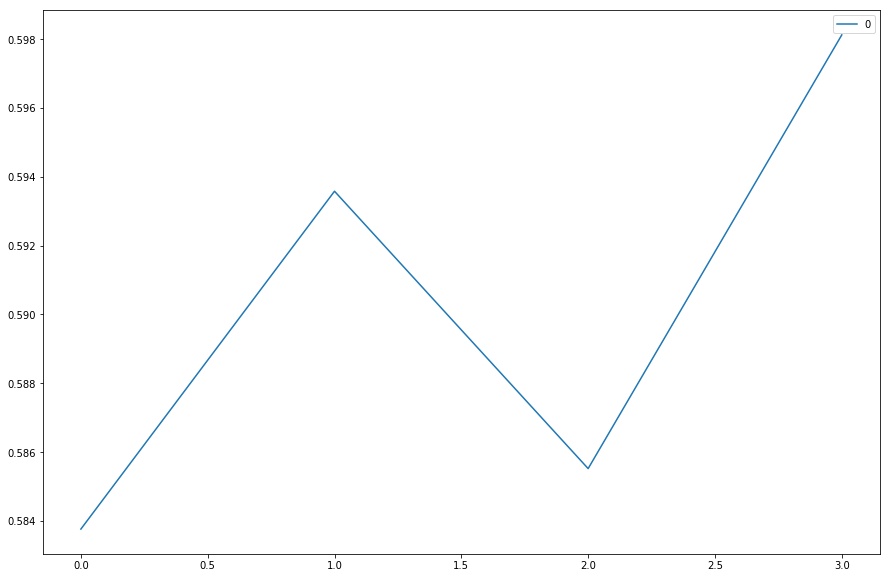

In [9]:
%matplotlib inline
pd.DataFrame(gridSearch.cv_results_['mean_test_score']).plot(figsize=(15,10))

Grid search indicates that below parameters give the best accuracy:

* min_child_weight=10
* max_depth=8
* learning_rate=0.1


## Fit final model

In [10]:
import xgboost as xgb

gbm = xgb.XGBClassifier(
    min_child_weight=10,
    max_depth=8,
    learning_rate=0.1,
    objective = "multi:softprob",
    n_estimators=100,
    eval_metric ="mlogloss",
    n_jobs=2,
    tree_method='gpu_hist',
    n_gpus=1)


gbm.fit(mergedXTrain, YTrain.intention, early_stopping_rounds=10, eval_set=[(mergedXTrain,YTrain.intention)], eval_metric='mlogloss')

[0]	validation_0-mlogloss:3.51419
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:3.2654
[2]	validation_0-mlogloss:3.06671
[3]	validation_0-mlogloss:2.89602
[4]	validation_0-mlogloss:2.74498
[5]	validation_0-mlogloss:2.61242
[6]	validation_0-mlogloss:2.49391
[7]	validation_0-mlogloss:2.38286
[8]	validation_0-mlogloss:2.28347
[9]	validation_0-mlogloss:2.19013
[10]	validation_0-mlogloss:2.10143
[11]	validation_0-mlogloss:2.02277
[12]	validation_0-mlogloss:1.9479
[13]	validation_0-mlogloss:1.8759
[14]	validation_0-mlogloss:1.8087
[15]	validation_0-mlogloss:1.74521
[16]	validation_0-mlogloss:1.6849
[17]	validation_0-mlogloss:1.62621
[18]	validation_0-mlogloss:1.57102
[19]	validation_0-mlogloss:1.51784
[20]	validation_0-mlogloss:1.46735
[21]	validation_0-mlogloss:1.41904
[22]	validation_0-mlogloss:1.37201
[23]	validation_0-mlogloss:1.3297
[24]	validation_0-mlogloss:1.28598
[25]	validation_0-mlogloss:1.24437
[26]	validation_0-mlogloss:1.20533
[2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=100, n_gpus=1,
       n_jobs=2, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [15]:
pd.Series(gbm.feature_importances_).describe()

count    672.000000
mean       0.001488
std        0.000972
min        0.000000
25%        0.000964
50%        0.001302
75%        0.001712
max        0.007256
dtype: float64

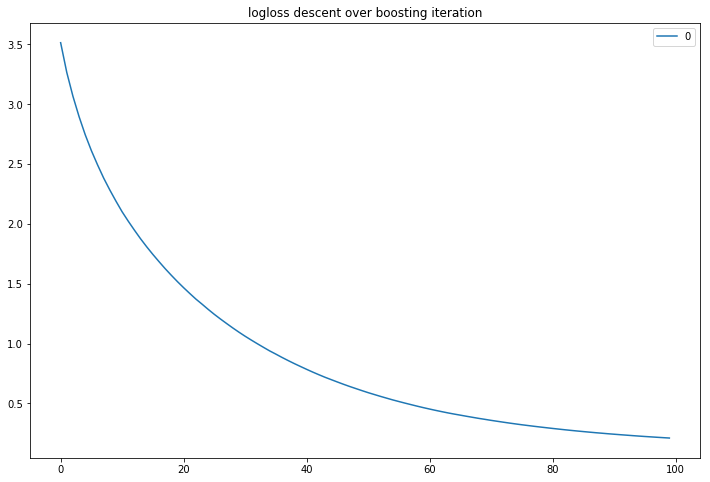

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.DataFrame(gbm.evals_result_.get('validation_0').get('mlogloss')).plot(figsize=(12,8), title='logloss descent over boosting iteration')

In [17]:
YPredicted = gbm.predict(mergedXTest)
YTrue = YTest.intention

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.85      0.31      0.46        35
          1       0.00      0.00      0.00         4
          2       1.00      0.20      0.33         5
          3       0.00      0.00      0.00         1
          4       0.89      0.73      0.80        11
          5       0.50      0.17      0.25        18
          6       1.00      0.50      0.67         4
          7       0.00      0.00      0.00         1
          8       0.76      0.52      0.62        25
          9       0.25      0.14      0.18         7
         10       0.60      0.50      0.55        12
         11       0.50      0.26      0.34        27
         12       0.27      0.50      0.35         6
         13       0.57      0.67      0.62        12
         14       0.43      0.48      0.45        42
         15       0.50      1.00      0.67         4
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00   

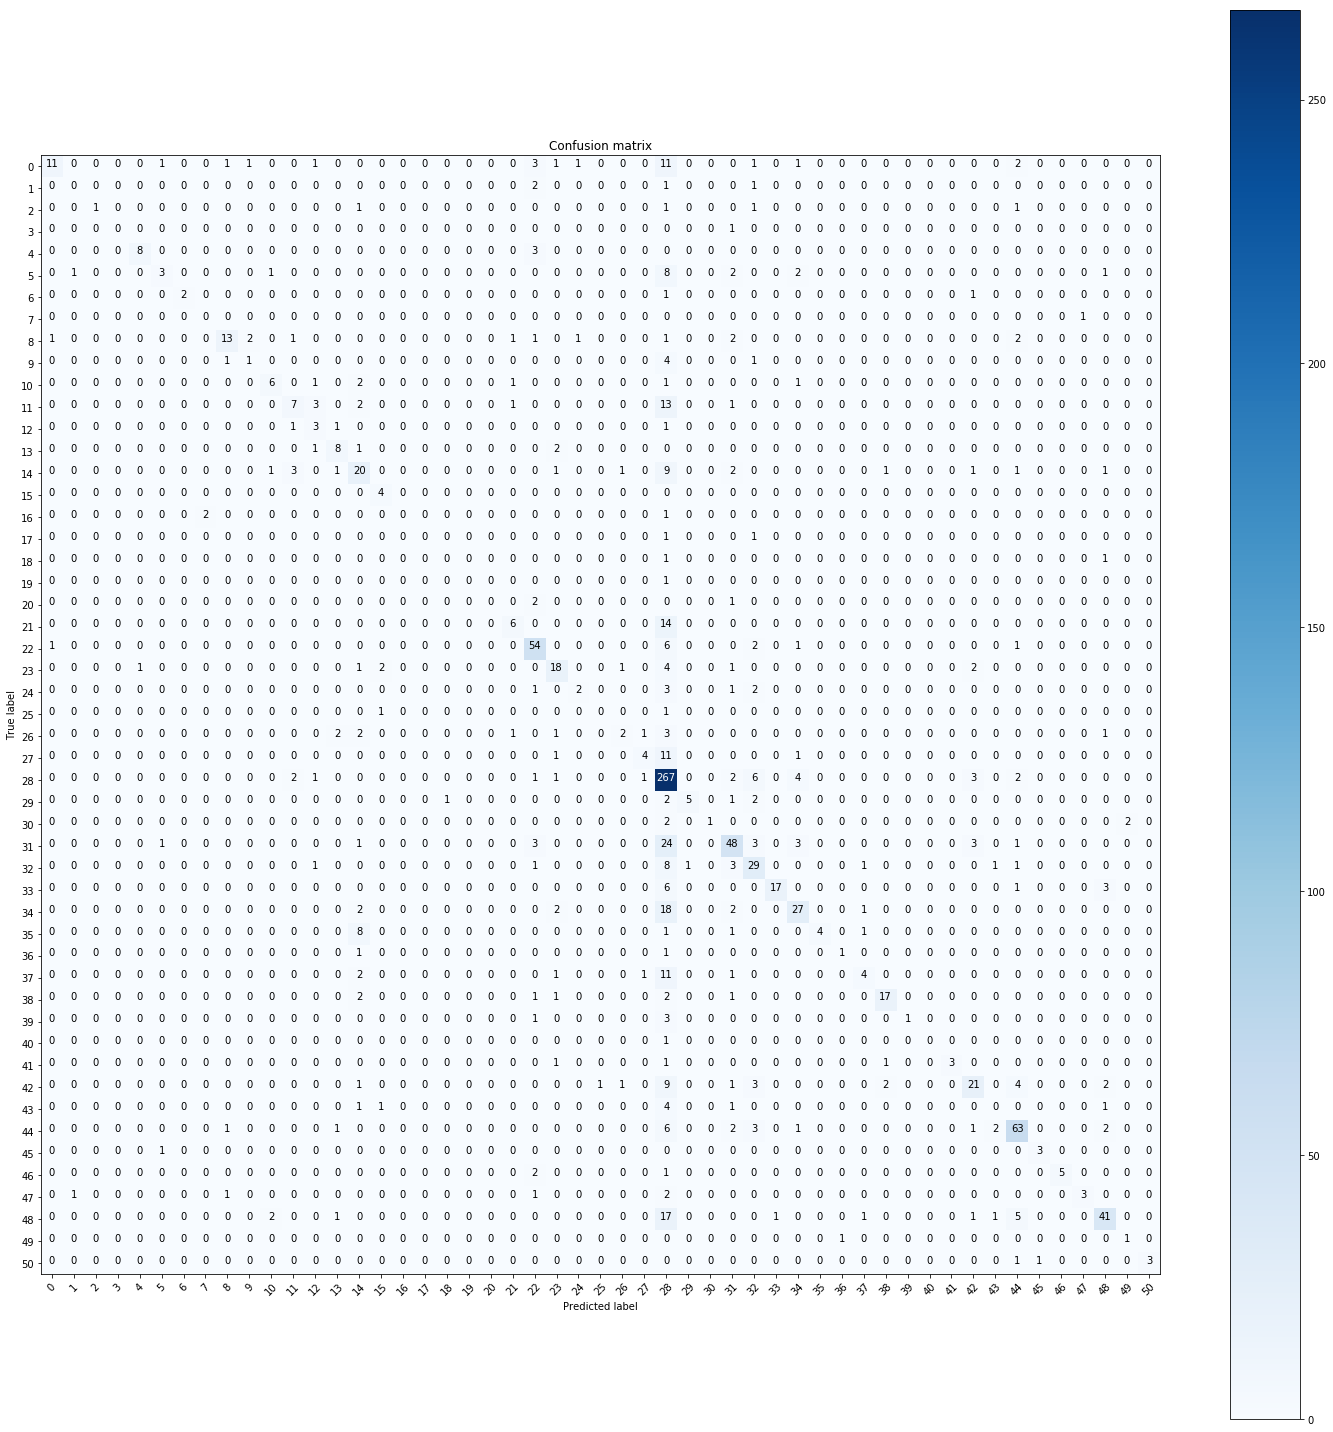

In [18]:

import sys
sys.path.append('..')
from utils import vizu

import sklearn
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()


In [29]:
macroF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='macro')
microF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='micro')
print ("micro F1 score = {:1.4f} ; macro F1 score = {:1.4f}".format(microF1Score, macroF1Score))

micro F1 score = 0.6116 ; macro F1 score = 0.4122


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
